# Project: (K-) Nearest Neighbors

Adrian Alejandro Vacca Bonilla

Computational Machine Learning

Barcelona School of Economics 2024-2025


This project aims to predict patient mortality in an ICU setting using various machine learning techniques. We use clinical data to build predictive models that classify whether a patient is at risk of mortality during their ICU stay.

**Objectives:**
- Data preprocessing and feature engineering
- Exploratory Data Analysis (EDA)
- Model training, selection, and evaluation
- Submitting predictions in the format required for the Kaggle competition

**Dataset**: ICU dataset with patient demographic information, lab results, and other clinical variables.


## Assignment

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.



# Project Development



## Preparing the Environment

Before diving into our project, we'll ensure our workspace is ready. This involves setting up the necessary tools and resources.

**Mounting Google Drive**

To access our project files stored on Google Cloud Drive, we'll mount the drive to our local machine.

In [ ]:
## Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Classroom/22D017 Computational Machine Learning 24-25 DSM  T1/Materials/1Project/kaggleData')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing requeried libraries**

To begin our analysis, we'll import several python libraries such.

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

np.random.seed(3123) # impose random seed for reproducibility

**Loading Kaggle Data**

We'll load Kaggle Datasets into Pandas DataFrames.



In [ ]:
# Train data
train_data=pd.read_csv('mimic_train.csv')
#train_data.head()

# Test dataset (to produce predictions)
test_data=pd.read_csv('mimic_X_test.csv')
#test_data.sort_values('icustay_id').head()

# Diagnosis metadata
diagnosis_metadata = pd.read_csv('MIMIC_metadata_diagnose.csv')

## Data Preprocessing

In this section, we load the data, handle missing values, and perform any necessary feature engineering to prepare the data for modeling.

## Analyzing current data

**Missing values analysis**

Let's explore missing values in our dataset. The following visualization provides a clear overview of the percentage of missing data per column.

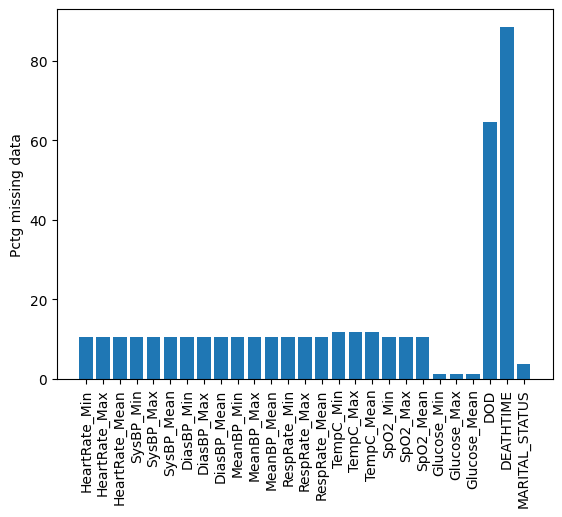

In [ ]:
Nulls = train_data.isnull().sum()
from IPython.display import display, HTML
Nulls = Nulls[Nulls > 0]

plt.xticks(rotation='vertical')
plt.bar(Nulls.index, 100*Nulls.values/len(train_data.index))
plt.ylabel('Pctg missing data')
plt.show()


As it is shown DEATHTIME and DOD have the highest percentage of missing data, suggesting that these features might not be useful in our model.

For the remaining columns with less than 20% of missing data, we can use an Imputer instead of discarding rows. This allows us to preserve more data and potentially improve model performance.

**Categorical values analysis**

Let's explore categorical features (dates/strings)  to consider encoding/droping strategies.

In [ ]:
no_numerical = train_data.select_dtypes(exclude=[np.number, bool])
no_numerical_test = test_data.select_dtypes(exclude=[np.number, bool])
no_numerical.head()

,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,F,2120-12-07 00:00:00,NaN,2183-03-14 16:11:00,2183-03-21 14:07:00,NaN,EMERGENCY,Medicare,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,ASTHMA;CHRONIC OBST PULM DISEASE,49121,MICU
1,F,2103-03-10 00:00:00,NaN,2165-04-04 02:25:00,2165-04-16 14:41:00,NaN,EMERGENCY,Private,EPISCOPALIAN,DIVORCED,WHITE,S/P PEDESTRIAN STRUCK,80620,TSICU
2,M,2104-08-12 00:00:00,NaN,2177-06-23 12:33:00,2177-07-07 12:45:00,NaN,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,STERNAL WOUND INFECTION,99859,CSRU
3,M,2105-07-06 00:00:00,2167-07-19 00:00:00,2167-07-17 21:34:00,2167-07-19 21:34:00,2167-07-19 21:34:00,EMERGENCY,Private,CATHOLIC,MARRIED,BLACK/AFRICAN AMERICAN,SEPSIS,27652,MICU
4,M,2112-12-12 00:00:00,2177-03-05 00:00:00,2174-03-09 12:17:00,2174-03-31 16:00:00,NaN,EMERGENCY,Medicaid,NOT SPECIFIED,DIVORCED,WHITE,BILE LEAK,9974,MICU


Let's remove columns that don't contribute to our analysis: datetimes, unique identifiers, `DOB`, `DOD`, `INSURANCE`, `ETHNICITY`, `MARITAL_STATUS`, `FIRST_CAREUNIT` and `RELIGION`.

In [ ]:
data = train_data.copy()
data_test = test_data.copy()

data = data.drop(['ADMITTIME', 'DISCHTIME',  'DOB', 'DOD', 'DEATHTIME', 'subject_id', 'Unnamed: 0', 'hadm_id', 'MARITAL_STATUS', 'RELIGION', 'INSURANCE', 'ETHNICITY', 'FIRST_CAREUNIT'], axis=1)
data_test = data_test.drop(['ADMITTIME', 'DISCHTIME', 'DOB', 'DOD', 'DEATHTIME', 'subject_id', 'Unnamed: 0', 'hadm_id', 'MARITAL_STATUS', 'RELIGION', 'INSURANCE', 'ETHNICITY', 'FIRST_CAREUNIT'], axis=1)

**One Hot encoding**

We consider one hot encoding (convert to binary dummy variables) is a good approach for the features `GENDER` and `ADMISION_TYPE` due to their low cardinality.

In [ ]:
data = pd.get_dummies(data, prefix=['GENDER'], columns=['GENDER'], drop_first=True)
data_test = pd.get_dummies(data_test, prefix=['GENDER'], columns=['GENDER'], drop_first=True)

data = pd.get_dummies(data, prefix=['ADM'], columns=['ADMISSION_TYPE'], drop_first = True)
data_test = pd.get_dummies(data_test, prefix=['ADM'], columns=['ADMISSION_TYPE'], drop_first = True)


**Encode ICD9_Diagnosis**

Let's transform our categorical ICD9_Diagnosis codes into numerical values using label encoding. Label encoding is a technique used to convert categorical variables into numerical codes. It assigns a unique integer to each category.


In [ ]:
le = LabelEncoder()
all_codes = pd.concat([diagnosis_metadata['ICD9_CODE'].astype(str), data['ICD9_diagnosis'].astype(str), data_test['ICD9_diagnosis'].astype(str)]).unique()
le.fit(all_codes)
data['ICD9_diagnosis'] = le.transform(data['ICD9_diagnosis'])
data_test['ICD9_diagnosis'] = le.transform(data_test['ICD9_diagnosis'])

**Impute values**

A simple imputer is a technique used to handle missing values in a dataset. It replaces missing values with a specified value, such as the mean, median, or mode of the column. Le's use a Simple Imputer to fill missing numerical values.

In [ ]:
# Get only numerical and boolean columns
data = data.select_dtypes(include=[np.number, bool])
data_test = data_test.select_dtypes(include=[np.number, bool])

#delete icustay_id
data_test_with_id = data_test.copy()
data = data.drop(['icustay_id'], axis=1)
data_test = data_test.drop(['icustay_id'], axis=1)

# Separate features and target variable before imputation
X = data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
y = data['HOSPITAL_EXPIRE_FLAG']

# Impute missing values with the mean in the features only
imputer = SimpleImputer(strategy='mean')

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
data_test = pd.DataFrame(imputer.transform(data_test), columns=data_test.columns)

X.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,ICD9_diagnosis,LOS,GENDER_M,ADM_EMERGENCY,ADM_URGENT
0,89.0,116.0,102.677419,97.0,150.0,126.000000,62.0,95.0,76.142857,71.0,...,97.900000,88.0,200.0,155.000000,-63883.78340,5209.0,6.1397,0.0,1.0,0.0
1,74.0,114.0,92.204082,87.0,160.0,122.000000,35.0,75.0,53.020000,16.0,...,95.897959,153.0,213.0,187.000000,-56421.13544,9993.0,10.2897,0.0,1.0,0.0
2,59.0,89.0,70.581395,88.0,160.0,120.933333,43.0,70.0,51.688889,55.0,...,99.674419,73.0,113.0,88.333333,-60754.35504,12145.0,5.8080,1.0,1.0,0.0
3,75.0,86.0,80.400000,74.0,102.0,85.227273,47.0,69.0,59.636364,54.0,...,93.809524,68.0,68.0,68.000000,-56609.91884,2534.0,2.3536,1.0,1.0,0.0
4,77.0,107.0,91.020408,95.0,150.0,108.625000,39.0,132.0,57.500000,56.0,...,95.673469,73.0,117.0,92.666667,-59200.37377,12118.0,19.3935,1.0,1.0,0.0


## Model Training and Evaluation

We'll experiment with different KNN model configurations by tuning hyperparameters like the number of neighbors. Cross-validation will be used to evaluate the performance of each configuration and select the best model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameters to be tested
k_values = range(1, 16)
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']

best_k = None
best_algorithm = None
best_weight = None
best_auc = 0

# Perform cross-validation to find the best parameters
for k in k_values:
  for algorithm in algorithms:
    for weight in weights:
      knn = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm, weights=weight)
      knn.fit(X_train, y_train)
      y_val_pred = knn.predict_proba(X_val)[:, 1]
      auc = roc_auc_score(y_val, y_val_pred)

      if auc > best_auc:
        best_auc = auc
        best_k = k
        best_algorithm = algorithm
        best_weight = weight

print(f"Best k: {best_k}")
print(f"Best algorithm: {best_algorithm}")
print(f"Best weight: {best_weight}")
print(f"Best AUC: {best_auc}")

Best k: 15
Best algorithm: auto
Best weight: distance
Best AUC: 0.609693439022061


## Predict on the test data

It's time to make predictions on the unseen test data.

In [ ]:
# Train the final model with the best parameters
knn_final = KNeighborsClassifier(n_neighbors=best_k, algorithm=best_algorithm, weights=best_weight)
knn_final.fit(X, y)

# Make predictions on the test data
y_test_pred = knn_final.predict_proba(data_test)[:, 1]

## Kaggle Predictions Submissions

We generate this csv file to be uploaded to Kaggle and evaluate our prediction.

In [ ]:
# Create a submission dataframe
submission_df = pd.DataFrame({'icustay_id': data_test_with_id['icustay_id'], 'HOSPITAL_EXPIRE_FLAG': y_test_pred})

# Save the submission to a CSV file
submission_df.to_csv('submission.csv', index=False)